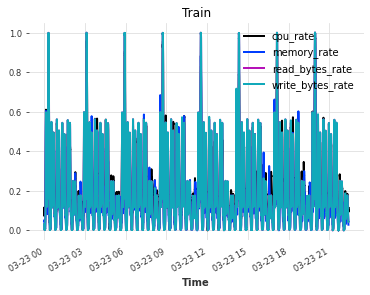

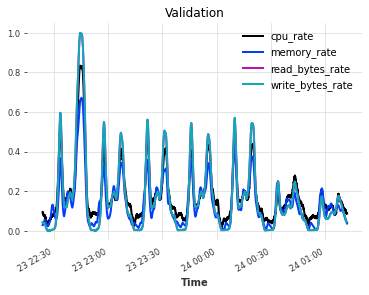

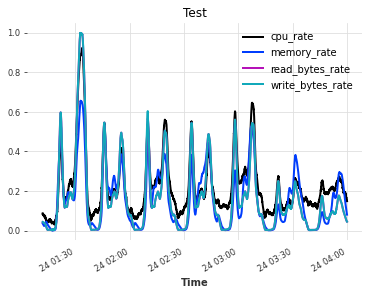

In [1]:
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["LD_LIBRARY_PATH"] = "/home/jupyter-babakesistani/.conda/envs/thesis/lib/"


import torch
import numpy as np
import random

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.use_deterministic_algorithms(True)
np.random.seed(seed)


import pandas as pd
from darts.models import (
    BlockRNNModel,
)
from darts.utils.likelihood_models import QuantileRegression
from darts.dataprocessing.transformers import Scaler
import matplotlib.pyplot as plt
from darts.metrics import rho_risk
import matplotlib.pyplot as plt

import sys
sys.path.append("/home/jupyter-babakesistani/adaptive-monitoring-nn/")
from pipeline.dataset.dataset_loader import DatasetLoader



dl =  DatasetLoader( '/home/jupyter-babakesistani/adaptive-monitoring-nn/pipeline/data/cpu_memory_disk_23_march.csv', "Time",
                                                                    [
                                                                      "cpu_rate",
                                                                      "memory_rate",
                                                                      "read_bytes_rate",
                                                                      "write_bytes_rate"
                                                                     ],
                    augment=False, resample_freq="1s", shift_df_datetime="2022-03-23 00:00:00")
scaled_one_day = 24*60
scaled_one_week = 7*24*60
idx_train = 8*scaled_one_week
idx_val = 9*scaled_one_week
train = dl.series_scaled[:idx_train]
val = dl.series_scaled[idx_train:idx_val]
test = dl.series_scaled[idx_val:-1]
    
train.plot()
plt.title("Train")

val.plot(new_plot=True)
plt.title("Validation")

test.plot(new_plot=True)
plt.title("Test")

def day_of_week(idxs):
    days = ((idxs.second + idxs.minute*60 + idxs.hour*60*60 + idxs.dayofweek*24*60*60) // (24*60)) % 7
    encoders = []
    for day in days:
        if day == 0:
            encoders.append(1)
        elif day == 1 or day == 2 or day == 3 or day == 4: 
            encoders.append(2)
        elif day == 5 or day == 6:
            encoders.append(3)
    return encoders

def minute_of_day(idxs):    
    minute_of_day = ((idxs.second + idxs.minute*60 + idxs.hour*60*60 + idxs.dayofweek*24*60*60) % (24*60))
    return minute_of_day



In [2]:
model = BlockRNNModel.load_from_checkpoint("LSTM_23march_300_600",work_dir="../Training/logs/lstm_23march_300_600/", best=True)

[2022-05-24 14:44:12,478] INFO | darts.models.forecasting.torch_forecasting_model | loading model_best_82.pth.tar
[2022-05-24 14:44:12,478] INFO | darts.models.forecasting.torch_forecasting_model | loading model_best_82.pth.tar


In [3]:
from typing import Union, Optional
DIMS = ("time", "component", "sample")
def plot_custom(
        self,
        new_plot: bool = False,
        central_quantile: Union[float, str] = 0.5,
        low_quantile: Optional[float] = 0.1,
        high_quantile: Optional[float] = 0.9,
        *args,
        **kwargs,
    ):
        alpha_confidence_intvls = 0.25

        fig = (
            plt.figure()
            if new_plot
            else (kwargs["figure"] if "figure" in kwargs else plt.gcf())
        )
        kwargs["figure"] = fig
        label = kwargs["label"] if "label" in kwargs else ""

        if not any(lw in kwargs for lw in ["lw", "linewidth"]):
            kwargs["lw"] = 2

        if self.n_components > 10:
            logger.warn(
                "Number of components is larger than 10 ({}). Plotting only the first 10 components.".format(
                    self.n_components
                )
            )

        for i, c in enumerate(self._xa.component[:10]):
            comp_name = str(c.values)

            if i > 0:
                kwargs["figure"] = plt.gcf()

            comp = self._xa.sel(component=c)

            if comp.sample.size > 1:
                if central_quantile == "mean":
                    central_series = comp.mean(dim=DIMS[2])
                else:
                    central_series = comp.quantile(q=central_quantile, dim=DIMS[2])
            else:
                central_series = comp.mean(dim=DIMS[2])

            # temporarily set alpha to 1 to plot the central value (this way alpha impacts only the confidence intvls)
            alpha = kwargs["alpha"] if "alpha" in kwargs else None
            kwargs["alpha"] = 1

            label_to_use = (
                (label + ("_" + str(i) if len(self.components) > 1 else ""))
                if label != ""
                else "" + str(comp_name)
            )
#             kwargs["label"] = label_to_use

            p = central_series.plot(*args, **kwargs)
            color_used = p[0].get_color()
            kwargs["alpha"] = alpha if alpha is not None else alpha_confidence_intvls

            # Optionally show confidence intervals
            if (
                comp.sample.size > 1
                and low_quantile is not None
                and high_quantile is not None
            ):
                low_series = comp.quantile(q=low_quantile, dim=DIMS[2])
                high_series = comp.quantile(q=high_quantile, dim=DIMS[2])
                plt.fill_between(
                    self.time_index,
                    low_series,
                    high_series,
                    color=color_used,
                    alpha=(
                        alpha_confidence_intvls
                        if "alpha" not in kwargs
                        else kwargs["alpha"]
                    ),
                )

        plt.legend()
        plt.title(self._xa.name)


In [4]:
def merge_prediction_fetched_series(prediction, fetched_series) :
        if len(fetched_series.columns) == len(prediction.columns):
            return fetched_series

        if prediction.start_time() != fetched_series.start_time():
            print("prediction and fetched series start time are different: " \
                            + str(prediction.start_time()) + "<>" + str(fetched_series.start_time()))
            raise NotImplementedError
        
        if prediction.end_time() < fetched_series.end_time():
            print("prediction and fetched series end time are different: " \
                            + str(prediction.end_time()) + "<>" + str(fetched_series.end_time()))
            raise NotImplementedError
        prediction_components = prediction.components.to_list()
        fetched_series_components = fetched_series.components.to_list()
        result = None
        
        for component in prediction_components:
            if not result:
                if component in fetched_series_components:
                    result = fetched_series[component]
                    continue
                result = prediction[component]
                continue
            if component in fetched_series_components:
                result = result.concatenate(fetched_series[component], axis=1)
                continue
            result = result.concatenate(prediction[component], axis=1)
        return result

def get_cols_to_fetch(prediction, std_threshold):
    cols_to_fetch = []
    for i, component in enumerate(prediction.components):  
        pred = prediction.univariate_component(i)
        pred = pred.all_values()  # Time X Components X samples
        pred = np.squeeze(pred)  # Time X samples
        std = np.mean(np.std(pred, axis=1))
        if std > std_threshold:
            cols_to_fetch.append(component)
    return cols_to_fetch

In [15]:
std_th = 0.015

eval_test = test

saved_pct = {}
test_cols = eval_test.columns.to_list()
for test_col in test_cols:
    saved_pct[test_col] = []
print("std_th:", str(std_th))

col_map = {}
col_pct = {}

for test_col in test_cols:
    col_map[test_col] = 0
fetch_len = 300
pred_len = 600
last_fetch_len = 0
len_test = len(eval_test)
len_cols = len(eval_test.columns)
series_to_predict = eval_test[last_fetch_len:last_fetch_len+fetch_len]
last_fetch_len = last_fetch_len+fetch_len
test_cols = eval_test.columns.to_list()

#already fetched one series 
pred_fetch_series = series_to_predict.pd_dataframe()

plot_dic = {}
for test_col in test_cols:
    plot_dic[test_col] = [series_to_predict[test_col]]


for test_col in test_cols:
    col_map[test_col] += fetch_len


stop = False
while(not stop):
    if last_fetch_len+pred_len >= len_test:
        stop = True
        pred_len = len_test - last_fetch_len
    pred = model.predict(series=series_to_predict, n=pred_len, num_samples=100)
    cols_to_fetch = get_cols_to_fetch (pred,std_th)
    single_prediction =  model.predict(series=series_to_predict, n=pred_len)
    if not cols_to_fetch:
        series_to_predict = single_prediction
        pred_fetch_series = pd.concat([pred_fetch_series,series_to_predict.pd_dataframe()])
        for test_col in test_cols:
            plot_dic[test_col].append(pred[test_col])
        last_fetch_len = last_fetch_len + pred_len
        continue

    for col_tmp in cols_to_fetch:
        col_map[col_tmp]+=pred_len
    
    fetched_series = eval_test[cols_to_fetch][last_fetch_len:last_fetch_len + pred_len]
    
    
    for test_col in test_cols:
        if test_col in cols_to_fetch:
            plot_dic[test_col].append(fetched_series[test_col])
        else:
            plot_dic[test_col].append(pred[test_col])
            
        
    series_to_predict = merge_prediction_fetched_series(single_prediction, fetched_series)

    pred_fetch_series = pd.concat([pred_fetch_series,series_to_predict.pd_dataframe()])
    
    last_fetch_len = last_fetch_len + pred_len

for col in col_map:
    saved_pct[col].append((col_map[col])/ len(eval_test) * 100.0)
saved_pct

std_th: 0.015


{'cpu_rate': [56.547619047619044],
 'memory_rate': [100.0],
 'read_bytes_rate': [14.880952380952381],
 'write_bytes_rate': [14.880952380952381]}

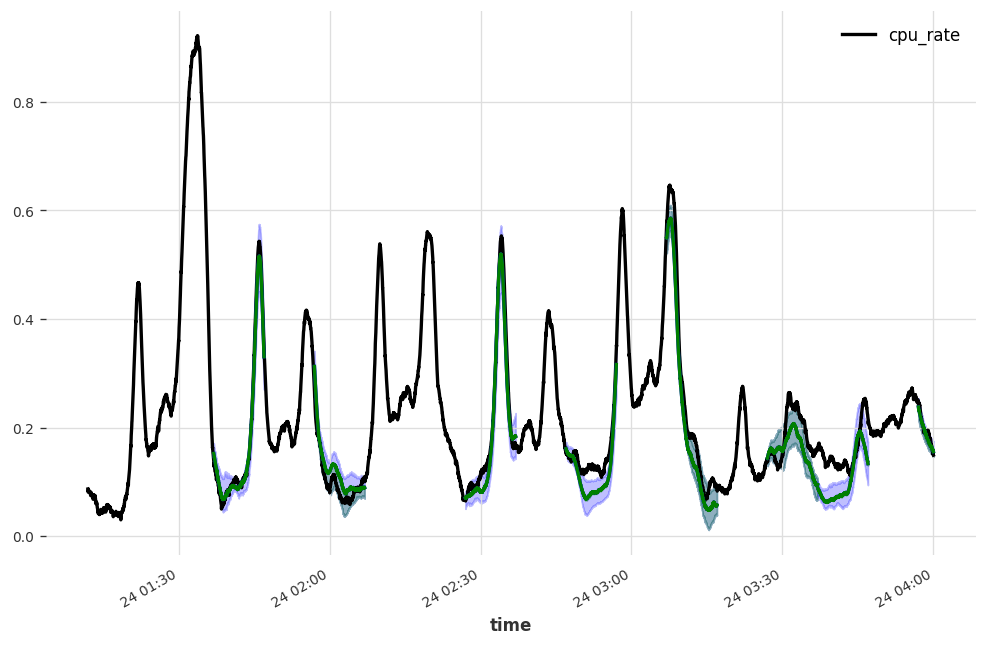

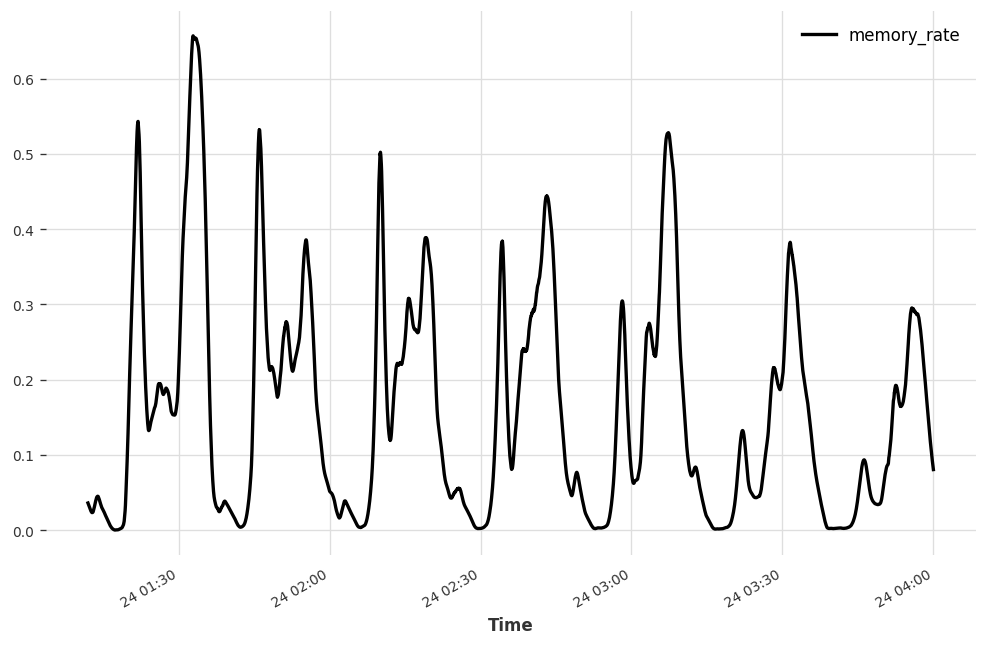

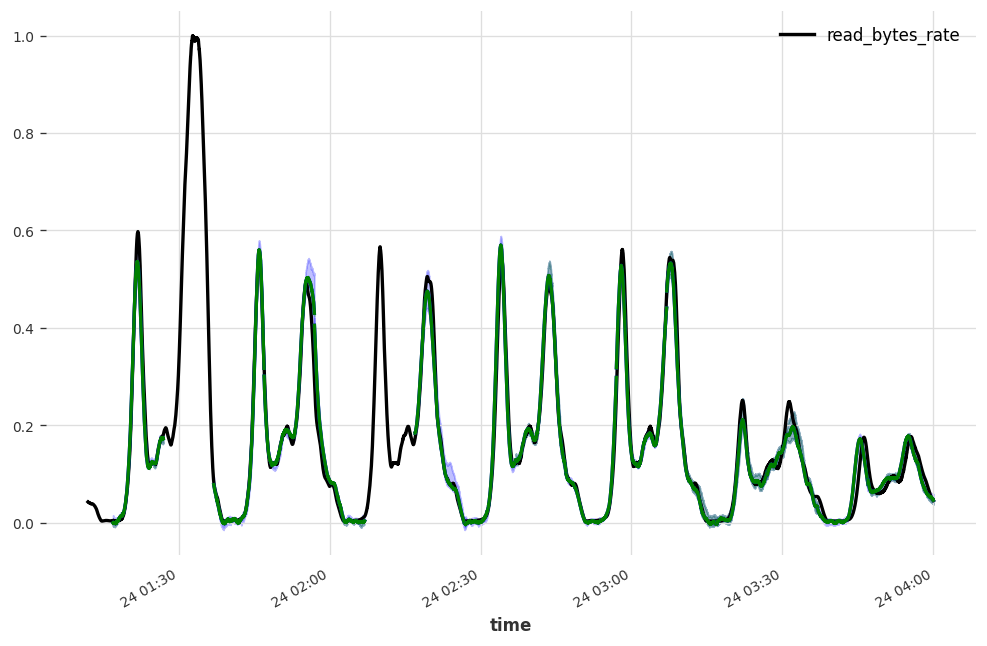

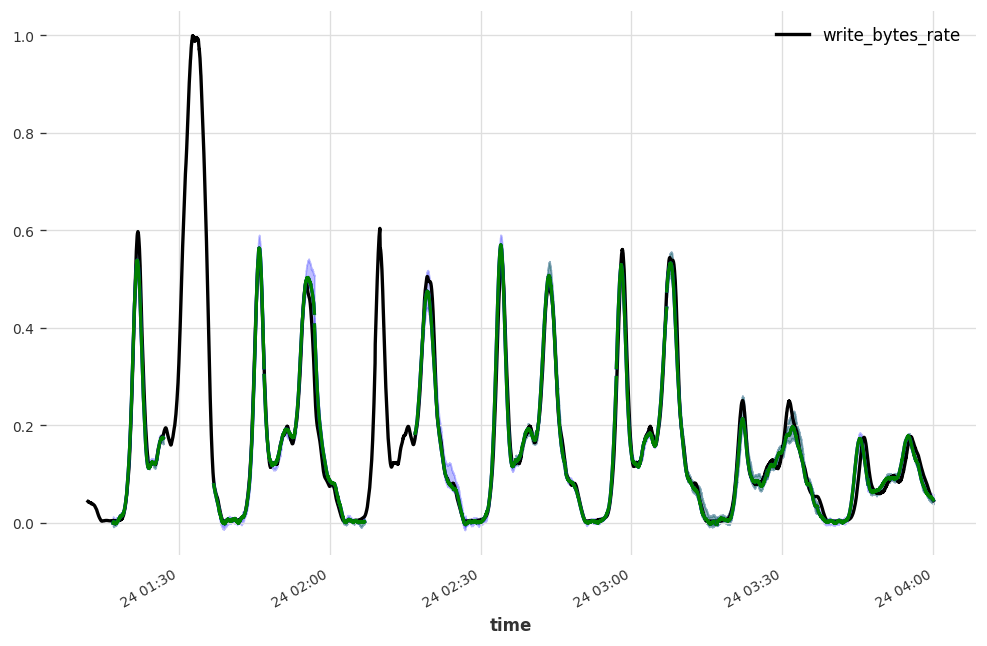

In [16]:
from matplotlib.pyplot import figure

for col_name in test_cols:

    figure(figsize=(10, 6), dpi=120)

    plots = []
    eval_test[col_name].plot()
    for series in plot_dic[col_name]:
        color="green"
        label="forecasted"
        label="ground_truth"
        if series.is_probabilistic:
            color="blue"
            plot_custom (series,low_quantile=0.01, high_quantile=0.99, color=color)
            plot_custom (series,low_quantile=0.1, high_quantile=0.9, color="green")
    plt.show()